In [1]:
import torch.nn as nn # importing torch.nn as nn

In [2]:
!pip install torch torchvision #installing torchvision package

In [3]:
import torch # importing torch
from torchvision import datasets # importing datasets from torchvision
from torchvision.transforms import ToTensor, Lambda #importing ToTensor and Lambda
from torch.utils.data import Dataset, random_split

In [4]:
import pandas as pd

In [5]:
import torch # importing torch
from torchvision import datasets # importing datasets from torchvision
from torchvision.transforms import ToTensor, Lambda #importing ToTensor and Lambda

ds_train = datasets.CIFAR10(  # Getting dataset (training) from FashionMNIST
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor(), # this converts the image into a tensor
    target_transform= Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0,torch.tensor(y), value=1))
    # This creates a tensor of zeros with a shape of (10,), indicating that there are 10 possible classes or labels. The dtype is set to float.
)

test_dataset = datasets.CIFAR10(  # Getting dataset (testing) from FashionMNIST
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor(), # this converts the image into a tensor
    target_transform= Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0,torch.tensor(y), value=1))
    # This creates a tensor of zeros with a shape of (10,), indicating that there are 10 possible classes or labels. The dtype is set to float.
)

100%|██████████| 170498071/170498071 [00:14<00:00, 12030982.43it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [6]:
# this chunk is used to get the validation datset from the training dataset
from torch.utils.data import random_split # importing random_split


train_size = len(ds_train) # taking length of the training set
val_size = int(0.1 * train_size)  # Taking 10% of the training set for validation

train_dataset, val_dataset = random_split(ds_train, [train_size - val_size, val_size]) # seperating into 90% of training into new training and 10% of training to validation

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")


Training set size: 45000
Validation set size: 5000


In [7]:
print(f"Test set size: {len(test_dataset)}")

Test set size: 10000


# Fine-tuning Code

## Loading the pretrained MobileNet_V2

In [8]:
import torch
import torchvision.models as models

model = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 21.7MB/s]


## Freezing the weights

In [9]:
for param in model.features.parameters():
    param.requires_grad = True

In [10]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

## Adding Additional Layers

In [11]:
import torch.nn as nn

In [12]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
num_classes = 10

model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, num_classes)
)



## Defining the Network Architecture

In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [15]:
net = model.to(device)
print(net)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [16]:
import torch.optim as optim #importing optim

In [17]:
criterion = nn.CrossEntropyLoss()  # Taking Cross Entropy Loss as the Loss function
optimizer = optim.RMSprop(net.parameters(), lr=0.0001)  # optimizer is SGD stochastic gradient descent


# Creating DataLoaders

In [18]:
from torch.utils.data import DataLoader # importing dataloader

In [19]:
# loading all the datasets into dataloader for feeding into the model by batches

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Printing the image

In [20]:
train_features,train_labels = next(iter(train_loader))

In [21]:
train_features[0].shape

torch.Size([3, 32, 32])

In [22]:
import torchvision

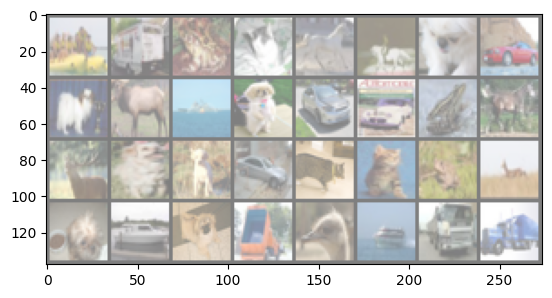

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))


## Training and Validating the Model

In [24]:
def trainval_loop(train_loader, val_loader, net, criterion, optimizer): #parameters for the function
    # Set the model to training mode before entering loops
    net.train()

    # Training loop
    size = len(train_loader.dataset)
    ret_train_loss = []
    ret_val_loss = []

    for batch, (X, y) in enumerate(train_loader):
        # Compute prediction and loss (training)
        X,y = X.to(device), y.to(device)
        pred = net(X)
        loss = criterion(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() # this is done to deny the involement of the previous gradients interference with the current ones

        if batch % 100 == 0:
            current = batch * len(X)
            print(f"Training loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]") #printing training loss
            ret_train_loss.append(loss.item())
    # Set the model to evaluation mode before validation
    net.eval()

    # Validation loop

    val_loss = 0
    val_size = len(val_loader.dataset)
    with torch.no_grad():  # No need to compute gradients during validation
        for batch, (X, y) in enumerate(val_loader):
            # Compute prediction and loss
            X,y = X.to(device), y.to(device)
            pred = net(X)
            loss = criterion(pred, y)
            val_loss += loss.item()


            if batch % 100 == 0:
                current = batch * len(X)
                print(f"Validation loss: {loss.item():>7f}  [{current:>5d}/{val_size:>5d}]") #printing validation loss
                ret_val_loss.append(loss.item())
    avg_val_loss = val_loss / len(val_loader)
    print(f"Avg. Validation loss: {avg_val_loss:>7f}") #printing average validation loss

    a = float(sum(ret_train_loss)/len(ret_train_loss))
    b = float(sum(ret_val_loss)/len(ret_val_loss))
    return a,b


## Testing the Model

In [25]:
# this chunk is important for testing the model
def test_loop(test_loader, net, criterion): # function test_loop taking these respective parameters
    net.eval() # setting the model to eval
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss, correct = 0, 0
    #confusion_matrix = np.zeros((10,10), dtype=np.int32)

    with torch.no_grad():
        for X, y in test_loader:
            X,y = X.to(device), y.to(device)
            pred = net(X)
            test_loss += criterion(pred, y).item()

            # Calculate the number of correct predictions in this batch
            pred_labels = pred.argmax(dim=1)
            y= y.argmax(dim=1)
            #print(pred_labels,y)
            correct += (pred_labels == y).sum().item()
            #confusion_matrix[pred_labels, y] += 1


    test_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {(100*accuracy):.2f}%, Avg loss: {test_loss:.8f} \n") # printint the Accuracy (TEST) and the test_loss
    #return confusion_matrix

## Now Training and Validation

In [26]:
epochs = 10
epoch_loss_train = []
epoch_loss_val = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    a,b = trainval_loop(train_loader,val_loader, net, criterion, optimizer) # running train_val loop by 10 times
    epoch_loss_train.append(a)
    epoch_loss_val.append(b)
print("Done!")

Epoch 1
-------------------------------
Training loss: 2.329836  [    0/45000]
Training loss: 1.565581  [ 3200/45000]
Training loss: 1.053201  [ 6400/45000]
Training loss: 1.335445  [ 9600/45000]
Training loss: 1.129048  [12800/45000]
Training loss: 1.060001  [16000/45000]
Training loss: 0.995324  [19200/45000]
Training loss: 0.989132  [22400/45000]
Training loss: 1.411223  [25600/45000]
Training loss: 0.991915  [28800/45000]
Training loss: 0.685576  [32000/45000]
Training loss: 1.021165  [35200/45000]
Training loss: 0.705951  [38400/45000]
Training loss: 1.058886  [41600/45000]
Training loss: 0.818630  [44800/45000]
Validation loss: 0.747042  [    0/ 5000]
Validation loss: 0.645394  [ 3200/ 5000]
Avg. Validation loss: 0.776790
Epoch 2
-------------------------------
Training loss: 0.747627  [    0/45000]
Training loss: 0.670921  [ 3200/45000]
Training loss: 0.934971  [ 6400/45000]
Training loss: 0.813037  [ 9600/45000]
Training loss: 0.986646  [12800/45000]
Training loss: 0.765254  [1

# We will plot losses now

In [27]:
epoch_loss_train

[1.1433942476908365,
 0.7911455074946085,
 0.6737809300422668,
 0.5530347297588984,
 0.4204708099365234,
 0.42718681395053865,
 0.41521126131216685,
 0.34905286928017937,
 0.37742068072160084,
 0.22775632441043853]

In [28]:
epoch_loss_val

[0.6962178647518158,
 0.6274073123931885,
 0.7280491888523102,
 0.6933152973651886,
 0.5745207369327545,
 0.610056146979332,
 0.5908735692501068,
 0.5448581874370575,
 0.6281825304031372,
 0.7026772499084473]

In [29]:
import matplotlib.pyplot as plt
import numpy as np

ypoints = np.arange(len(epoch_loss_train))

ypoints

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

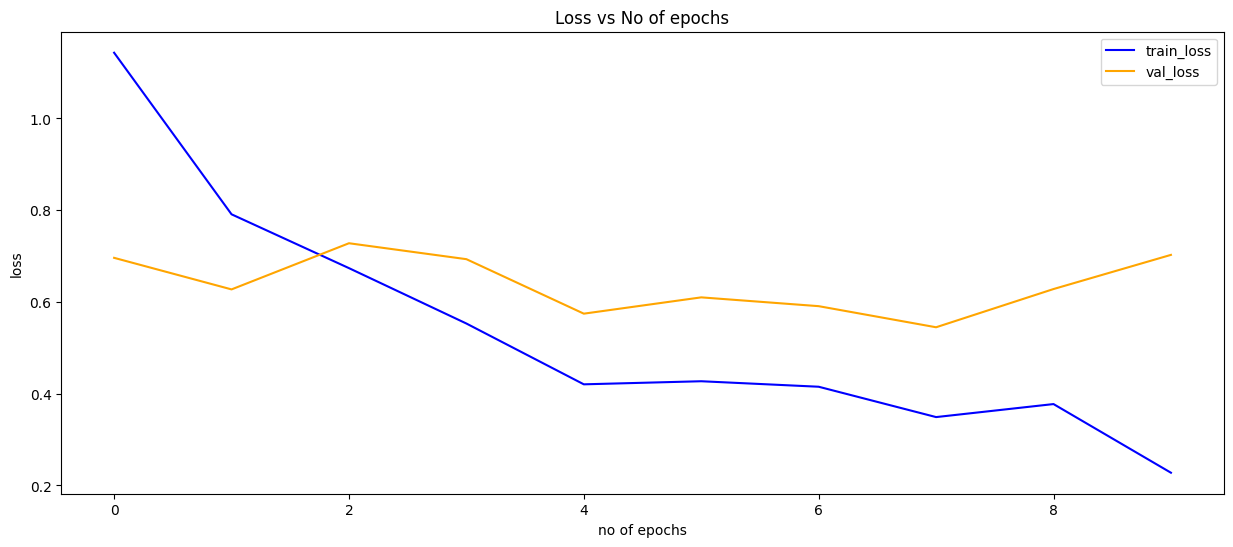

In [30]:
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [15, 6]
plt.plot(ypoints,epoch_loss_train, color='blue',label='Train')
plt.plot(ypoints,epoch_loss_val, color='orange',label='Validation')

plt.title("Loss vs No of epochs")
plt.xlabel("no of epochs")
plt.ylabel("loss")
plt.legend(["train_loss","val_loss"])
plt.show()

# Testing

In [31]:
test_loop(test_loader, net, criterion) #test_loop running and checking the results


Test Error: 
 Accuracy: 80.79%, Avg loss: 0.58450733 

